# Code Backend

In [9]:
import quantaq
import plotly.express as px
import pandas as pd
from quantaq.utils import to_dataframe
from tqdm.notebook import tqdm
from scipy.stats import variation
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import random
from scipy.stats import probplot
import plotly.graph_objects as go

from pandas.errors import MergeError

In [40]:
def load_data(batch, start, end, resample_length="1min", na_limit=0.15, device_list=[]):
    """
    `load_data` will download data from the testing chamber, 
    report and drop units with issues connecting, 
    and return a DataFrame. 

    :param batch: The name of the batch to pass to 
        the API for downloading.
    :type batch: string
    :param start: The start time of the data of interest, 
        formatted like: "2021-05-30 09:00:00".
    :type start: string
    :param end: The end time of the data of interest, 
        formatted like: "2021-05-30 09:00:00".
    :type end: string
    :param resample_length: The interval to be used in 
        resampling, defaults to "1min".
    :type resample_length: string
    :param na_limit: The maximum portion of reports that a unit 
        can skip (it is assumed that each unit should report as 
            many times as the most-reporting unit), defaults to 0.15.
    :type na_limit: float
    :param device_list: a subset of devices to run the analysis on (unless the list is empty and then it will run on all devices).  Format should just be a list of the numbers of the devices e.g. `[225,213,247]`. Defaults to [].
    :type device_list: list
    :return: A DataFrame with all the data, indexed by "timestamp".
    :rtype: DataFrame
    """
    sensor_cols = ['met.pressure', 'met.rh', 'met.temp', 'neph.bin0', 
                   'neph.bin1', 'neph.bin2', 'neph.bin3', 'neph.bin4', 
                   'neph.bin5', 'neph.pm1', 'neph.pm10', 'neph.pm25', 
                   'opc.bin0', 'opc.bin1', 'opc.bin10', 'opc.bin11', 
                   'opc.bin12', 'opc.bin13', 'opc.bin14', 'opc.bin15', 
                   'opc.bin16', 'opc.bin17', 'opc.bin18', 'opc.bin19', 
                   'opc.bin2', 'opc.bin20', 'opc.bin21', 'opc.bin22', 
                   'opc.bin23', 'opc.bin3', 'opc.bin4', 'opc.bin5', 
                   'opc.bin6', 'opc.bin7', 'opc.bin8', 'opc.bin9', 
                   'opc.pm1', 'opc.pm10', 'opc.pm25', 'opc.rh', 'opc.temp']
    nonsensor_cols = ['flag', 'sn', 'timestamp', 'timestamp_local', 
                      'url', 'geo.lat', 'geo.lon']   
    
    # Setup the API Client
    client = quantaq.QuantAQAPIClient()
    
    # Retrieve the devices
    devices = client.devices.list(team=batch)
    print(f"there are {len(devices)} devices")
    if not device_list==[]:
        device_list = ["MOD-PM-"+format(sn, '05d') for sn in device_list]
        devices = [each for each in devices if (each["sn"] in device_list)]
    frames = []
    unit_len = {}

    with tqdm(total=len(devices), desc="API Download") as pbar:
        for each in devices:
            if ((np.datetime64(each['last_seen']) > np.datetime64(start)) 
                & (np.datetime64(each['created']) < np.datetime64(end))):
                data = client.data.list(sn=each["sn"], start=start, 
                                        stop=end, raw=True, per_page=500)
                frame = to_dataframe(data)
                unit_len[each["sn"]] = len(frame)
                if len(frame)>0:
                    if (frame.drop(nonsensor_cols, axis=1).isna().sum().sum() 
                        == 0):
                        # Resample
                        frame = (frame
                                 .resample(resample_length, on='timestamp')
                                 .mean()
                                 .reset_index()
                                )
                        frame["sn"] = each["sn"]
                        # Append
                        frames.append(frame)
                    else:
                        na_frame = frame.drop(nonsensor_cols, axis=1).isna()
                        print(f"WARNING: Unit {each['sn']} returning "
                              f"unexpected missing values for "
                              f"{list(na_frame.columns[na_frame.sum()>0])}")
                else:
                    print(f"WARNING: Unit {each['sn']} not recording "
                          "in timeframe")
            else:
                print(f"WARNING: Unit {each['sn']} not connecting "
                      "in timeframe")
            pbar.update(1)

    frames = pd.concat(frames)

    # Set the datatype for the flag
    frames["flag"] = frames["flag"].astype("int8", errors='ignore')

    # Drop empty columns
    frames = frames.dropna(how='all', axis=1)
    
    # ID frames that give a lot of NaNs
    for key in unit_len:
        unit_len[key] = unit_len[key]/max(unit_len.values())
    low_data_sns = {key:val 
                    for (key,val) 
                    in unit_len.items() 
                    if val<(1-na_limit)
                   }
    if len(low_data_sns) > 0:
        for sn,missing_data_pct in low_data_sns.items():
            print(f"WARNING: Unit {sn} only reports "
                  f"{str(missing_data_pct*100)[:4]}% as much data as other units")
    
    # all non-reporting units have been filtered out at the point
    # low-reporting are still included
    sns_list = list(frames["sn"].unique())
    print(f"The number of recording units is {len(sns_list)}")
    
    # Set timestamp as index
    frames.set_index(frames["timestamp"], inplace=True)
    
    return frames

In [41]:
def flag_units(df, var, steady_start=None, steady_end=None, threshold_factor=2):
    """
    `flag_units` does something...

    :param df: The data to check for anomalies.
    :type df: DataFrame
    :param var: The variable to check for anomalies.
    :type var: string
    :param steady_start: Start of the time window to check for 
        anomalies. 
    :type steady_start: string, optional
    :param steady_end: End of the time window to check for anomalies.
    :type steady_end: string, optional
    :param threshold_factor: A unit will be flagged when it's "error" 
        is more than `threashold_factor` times as large as the 
        median "error".
    :type threshold_factor: float
    :return: a list of the prolbem units; a record of the 
        standard deviations for each unit
    :rtype: list; DataFrame
    """
    
    # build a multiindexed df with var as column, sn and timestamp as 
    # index, and restricted to the time between steady_start and 
    # steady_end
    df_steady = df[[var,"sn", "timestamp"]].copy()
    df_steady["timestamp"] = pd.to_datetime(df_steady["timestamp"])
    df_steady.set_index(["sn","timestamp"], inplace=True)
    if not (steady_start==None or steady_end==None):
        df_steady = (
         df_steady.loc[(slice(None),slice(steady_start,steady_end)),:])
    
    # compute the scaling factors (`var_scale`) needed so that each 
    # module will have the same mean over time (as is in `var_scaled`)
    var_scale = df_steady.groupby(level=0).mean()
    var_scale = var_scale.median()/var_scale
    
    # rebuild `df_steady` since we sliced it
    df_steady = df[[var,"sn", "timestamp"]].copy()
    df_steady["timestamp"] = pd.to_datetime(df_steady["timestamp"])
    df_steady.set_index(["sn","timestamp"], inplace=True)
    var_scaled = df_steady*var_scale
    
    var_scaled_trend = var_scaled.groupby(level=1).median()
    
    # If you'd like to look at the absolute difference instead of the
    # relitatve difference you can use the following commented out code
#     var_std_list = (var_scaled
#                     .subtract(var_scaled_trend, axis=0)
#                     .groupby(level=0)
#                     .std()/var_scaled.mean()
#                    )
#     var_std_threshold = var_std_list.median()[0]*threshold_factor
    
#     problem_units = list(
#         (var_std_list[var_std_list[var] > var_std_threshold])
#         .index
#     )
    
    # Here we will exclude from consideration those periods of time 
    # where the median is very low
    if var=="neph.bin0":
        var_scaled_trend[var_scaled_trend[var]<1000] = np.nan
    else:
        var_scaled_trend[var_scaled_trend[var]<50] = np.nan
    var_std_list = (var_scaled
                    .divide(var_scaled_trend, axis=0)
                    .groupby(level=0)
                    .std()
                   )
    var_std_threshold = var_std_list.median()[0]*threshold_factor
    
    problem_units = list(
        (var_std_list[var_std_list[var] > var_std_threshold])
        .index
    )
    
    if len(problem_units)>0:
        print(f"Median standard deviation for " 
              f"{var} is {var_std_list.median()[0]}")
        print(f"Modules which significantly deviate from the median in {var}:")
        print(
            var_std_list
            .loc[problem_units]
            .sort_values(by=var, ascending=False)
        )
        
        return problem_units, var_std_list
    else:
        print(f"No issues found with {var}.")
        return [], var_std_list

In [42]:
def scales(df, problem_dict, steady_start=None, steady_end=None):
    """
    In a given time window `scales` computes a scaling factor for 
    each unit so that each unit will have the same mean value over 
    the time window as the median unit does.

    :param df: The data to be scaled.
    :type df: DataFrame
    :param problem_dict: A dictionary which returns the problem 
        units for a given variable.numeraicly
    :type problem_dict: dictionary
    :param steady_start: Start of the time window to scale by. 
    :type steady_start: string, optional
    :param steady_end: End of the time window to scale by.
    :type steady_end: string, optional
    :return: The data unscaled; the data scaled; a dictionary 
        which gives the scalling factors for a given variable.
    :rtype: DataFrame; DataFrame; dictionary
    """
    
    df= df.copy()
    
    df_scaled = pd.DataFrame()
    scale_dict = {}
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.set_index(["sn", "timestamp"], inplace=True)
    df_unscaled = df[list(problem_dict.keys())].copy()
    for var in problem_dict.keys():
        if not (steady_start==None or steady_end==None):
            df_steady = (
                df.loc[(slice(None),slice(steady_start,steady_end)),var].copy()
            )
        else:
            df_steady = df.loc[:,var].copy()
        # compute the scaling factors (var_scale) needed so that each 
        # module will have the same mean over time (as in neph_scaled)
        var_scale = df_steady.groupby(level=0).mean()
        var_scale = var_scale.drop(problem_dict[var]).median()/var_scale
        scale_dict[var] = var_scale
        df_scaled.loc[:,var] = df_unscaled.loc[:,var]*var_scale
    
    return df_unscaled, df_scaled, scale_dict

In [43]:
def quartiles(df, problem_dict):
    """
    `quartiles` builds a DataFrame which gives the quartiles for each 
    of the variables

    :param df: The data to be processed.
    :type df: DataFrame
    :param problem_dict: A dictionary which for a given variable 
        will return the problem units from that variable to be 
        excluded from the quartile analysis.
    :type problem_dict: dictionary
    :return: A DataFrame indexed by quartile, with variables as columns.
    :rtype: DataFrame
    """
    
    df_quartile = pd.DataFrame()
    for var in list(problem_dict.keys()):
        if len(problem_dict[var])==0:
            df_quartile[var] =(
                df
                .groupby(level=1)
                .quantile(q=[0.25,0.50,0.75])
                .rename_axis(["timestamp","Q"])[var]
            )
        else:
            df_quartile[var] =(
                df
                .drop(problem_dict[var], level="sn")
                .groupby(level=1)
                .quantile(q=[0.25,0.50,0.75])
                .rename_axis(["timestamp","Q"])[var]
            )
    return df_quartile

In [44]:
def build_plot(df, df_q, units, var, mode="lines"):
    """
    `build_plot` constructs a plot of the data along with a line along 
    the median and a band for the middle 50% of values.

    :param df: The data to be plotted.
    :type df: DataFrame
    :param df_q: The quartile values from `quartiles`.
    :type df_q: DataFrame
    :param units: list of units to plot a line for
    :type units: list of strings
    :param var: variable to plot
    :type var: string
    :param mode: How the data should be plotted, defaults to "lines".
    :type mode: {"lines", "markers"}
    :return: A plot of the data with the trendline and band. 
    :rtype: plotly graphics object
    """
    
    fig = go.Figure()
    fig.add_trace(go.Scattergl(
        x=list(
            df_q
            .loc[(slice(None),0.50),var]
            .index
            .get_level_values("timestamp")
        ),
        y=list(df_q.loc[(slice(None),0.50),var]),
        hoverinfo="skip",
        line=dict(color='rgba(0,0,0,1)'),
        name="median"
    ))
    for unit in units:
        fig.add_trace(go.Scattergl(
            x = (df
                 .loc[(unit,slice(None)),:]
                 .index
                 .get_level_values("timestamp")),
            y = df.loc[(unit,slice(None)),:][var],
            mode = mode,
            name = unit
        ))
    fig.add_trace(go.Scattergl(
        x=(list(df_q
                .loc[(slice(None),0.25),var]
                .index
                .get_level_values("timestamp")
               )
           + list(df_q
                  .loc[(slice(None),0.75),var]
                  .index
                  .get_level_values("timestamp")
                 )[::-1]
          ),
        y=(list(df_q.loc[(slice(None),0.25),var])
           + list(df_q.loc[(slice(None),0.75),var])[::-1]),
        fill='toself',
        fillcolor='rgba(20,20,20,0.2)',
        hoverinfo="skip",
        line=dict(color='rgba(190,190,190,0)'),
        showlegend=False
    ))
    return fig

# Workflow

TO DO: make it easy to set different time windows for different variables. 

Below we load all the data into `df`

In [51]:
df = load_data(batch="QC-1", 
               start="2021-06-28 12:00:00", 
               end="2021-07-01 02:00:00",
               na_limit = 0.10,
               resample_length="1min"
              )

there are 12 devices


API Download:   0%|          | 0/12 [00:00<?, ?it/s]

The number of recording units is 12


Look at the below graph of humidity to see if any units appear not to be in the chamber.  If so you can make a list `not_in_chamber` and remove them from `df` as below.

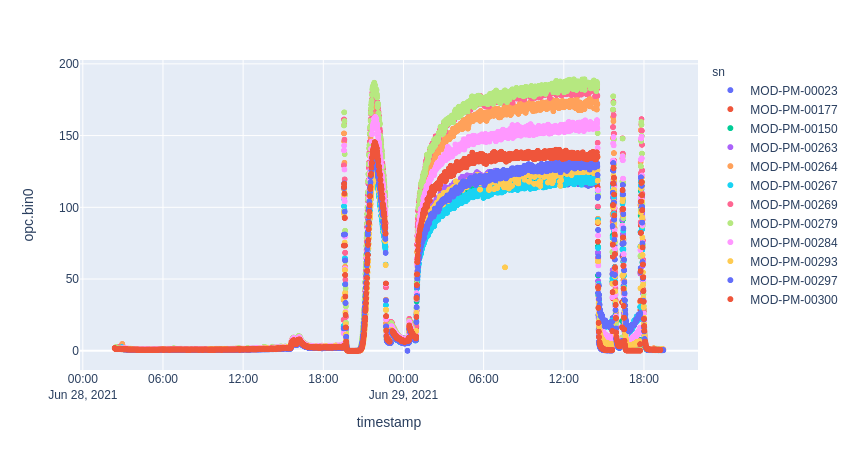

In [49]:
px.scatter(df, x="timestamp", y="opc.bin0", color="sn", render_mode="webgl")

In [ ]:
df.loc["2021-06-16 02:20:00":"2021-06-16 18:40:00","neph.bin0"] = np.nan

In [ ]:
df.loc["2021-06-16 20:30:00":,"opc.bin3"] = np.nan

In [19]:
not_in_chamber=["MOD-PM-00209", "MOD-PM-00210"]

In [20]:
df = df[~df["sn"].isin(not_in_chamber)]
all_units = df["sn"].unique()

Now that we know all the units in `df` are in the chamber.  We can use the below plot, to define an appropriate steady state window below.  This window is used for scaling the units - error will be looked for across all the data (except for where the median is small).

In [ ]:
px.scatter(df, x="timestamp", y="neph.bin0", color="sn", render_mode="webgl")

In [ ]:
steady_start = "2021-06-16 01:50:00"
steady_end = "2021-06-16 02:00:00"

In [ ]:
problem_dict = {} 
var_std_list = pd.DataFrame()
for var in ["neph.bin0", "opc.bin0", "opc.bin1", "opc.bin2", "opc.bin3"]:
    out1, out2 = flag_units(df, 
                            var, 
                            steady_start=steady_start, 
                            steady_end=steady_end, 
                            threshold_factor=1.5
                           )
    if var_std_list.empty:
        var_std_list = out2
    else:
        var_std_list = var_std_list.merge(out2, 
                                          left_index=True, 
                                          right_index=True
                                         )
#         var_std_list_alt = var_std_list_alt.merge(out3, 
#                                           left_index=True, 
#                                           right_index=True
#                                          )
    problem_dict[var] = out1

Now we will pick out the five best units.  We pick the best by summing the cost over all variables.  We might consider doing a weighted sum.

In [ ]:
best_units = list(var_std_list.sum(axis=1).sort_values()[:7].index)
print(best_units)

We will build a DataFrame, `df_scaled`, with the values for each unit scaled so that the average for each unit in a given variable is the same as the median unit for that variable.  The DataFrame is multiindexed by `sn` and `timestamp`, just like `df_unscaled` which is the same without the scaling factor havingn been applied. Given a variable, `scale_dict` will return the scaling factor for each unit for that variable.

In [ ]:
df_unscaled, df_scaled, scale_dict = scales(df, 
                                            problem_dict, 
                                            steady_start=steady_start, 
                                            steady_end=steady_end)

For each variable (scaled and also unscaled) we will compute the median and the quartiles at each timestep so we can and trend lines to our charts.

In [ ]:
df_quartile_scaled = quartiles(df_scaled, problem_dict)
df_quartile_unscaled = quartiles(df_unscaled, problem_dict)

Now we may build some graphs! Be sure to use the (un)scaled quartiles with the (un)scaled data.  And if you're using `problem_dict` be sure the key matches the variable you're plotting.  Here are a couple examples were we look at scaled data for `neph.bin0` for
* all units
* all units except for the ones that were flagged
* the flagged units
* the seven best units (these are the best averaged across all variables, not just `neph.bin0`)

In the first plot the units will be ordered in the legend by error levels. 

In [ ]:
build_plot(
    df_scaled, 
    df_quartile_scaled, 
    var_std_list.sort_values(by="neph.bin0",ascending=False).index, 
    "neph.bin0"
).show()

In [ ]:
build_plot(
    df_scaled, 
    df_quartile_scaled, 
    list(set(all_units)-set(problem_dict["neph.bin0"])), 
    "neph.bin0"
).show()

In [ ]:
build_plot(
    df_scaled, 
    df_quartile_scaled, 
    problem_dict["neph.bin0"], 
    "neph.bin0"
).show()

In [ ]:
build_plot(df_scaled, df_quartile_scaled, best_units, "neph.bin0").show()